# Differential Abundance

In [21]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import seaborn as sns
from scipy.stats import shapiro, kruskal, f_oneway
import numpy as np
    
%matplotlib inline

In [22]:
data_dir = 'data/'
data_dir_diff = 'data/differential_abundance/'

In [23]:
Visualization.load(f"{data_dir}/closed_reference_cluster/table-filtered.qzv")

<visualization: Visualization uuid: 6571fb47-d3e5-47b7-b684-a7f016aecfb2>

In [24]:
data = q2.Artifact.load(f'{data_dir}/closed_reference_cluster/table-filtered.qza').view(pd.DataFrame)

In [25]:
data.head()

,SH1326835.10FU_KY104094_reps,SH1218977.10FU_GQ329853_refs,SH1290755.10FU_KT799194_reps,SH1338507.10FU_MT974688_reps,SH1352130.10FU_UDB015372_refs,SH1070243.10FU_JN205919_refs,SH1079092.10FU_FR748051_refs,SH1307526.10FU_KU059952_reps,SH1060511.10FU_MK432703_reps,SH1330483.10FU_AF294699_refs,...,SH1382010.10FU_KC521541_reps,SH1357433.10FU_EU714323_refs,SH1254031.10FU_AJ271033_refs,SH1277533.10FU_AY046153_refs,SH1151321.10FU_HQ999978_refs,SH1402560.10FU_FM178254_refs,SH1307933.10FU_KY469041_reps,SH1300597.10FU_OU989370_reps,SH1083411.10FU_KJ081125_reps,SH1156729.10FU_KY103384_refs
SRR10505051,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10505052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10505053,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10505054,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10505055,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
top_three = data[data.sum()[:3].index]
top_three.columns

Index(['SH1326835.10FU_KY104094_reps', 'SH1218977.10FU_GQ329853_refs',
       'SH1290755.10FU_KT799194_reps'],
      dtype='object')

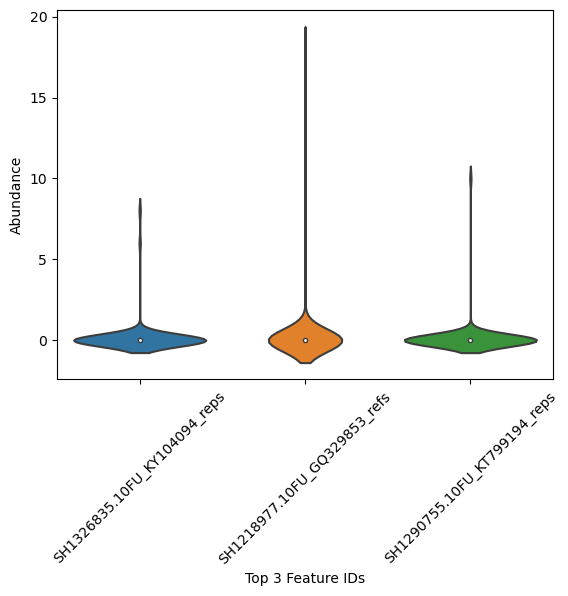

In [27]:
sns.violinplot(data = top_three)
plt.xlabel("Top 3 Feature IDs")
plt.ylabel("Abundance")
plt.xticks(rotation = 45)
plt.show()

In [28]:
n = 10

# draw n ASVs out of the original DataFrame
data_samp = data.sample(n = n, axis = 1, random_state = 234)

# create a new DataFrame with three columns (sample, ASV, abundance)
col_names = {'level_0': 'sample', 'level_1': 'asv', 0: 'count'}
data_plot = data_samp.stack().reset_index().rename(columns=col_names)

# make sure the shape is correct (no. of rows should be equal to the size of our random 
# sample multiplied by number of samples)
assert data_plot.shape[0] == n * data_samp.shape[0], 'The new DataFrame has an incorrect no. of rows.'

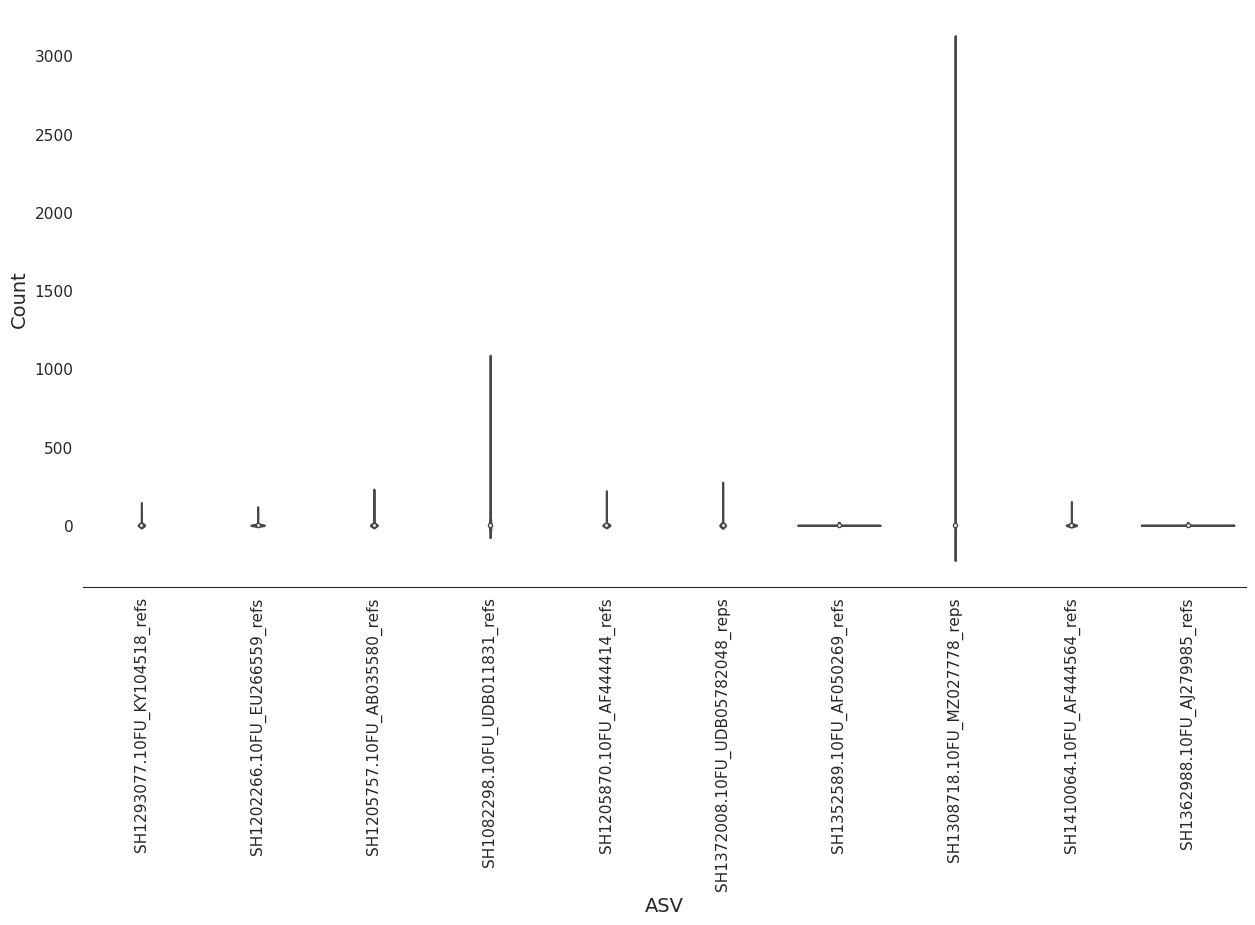

In [29]:
with sns.axes_style('white'), sns.color_palette('Set1'):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 7.5)
    
    sns.violinplot(data=data_plot, x='asv', y='count', ax=ax)
    sns.despine(left=True)
    
    # adjust tick labels and axes titles
    ax.tick_params(axis='x', rotation=90, labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.set_xlabel('ASV', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

## Test for Data Normality (Shapiro-Wilk Test)

In [30]:
alpha = 0.05
results = {}

# iterate through rows (samples) and test each of them for normality
for asv_name, asv_values in data.items():
    stat, p = shapiro(asv_values)
    results[asv_name] = p

# convert test results into a DataFrame
results_df = pd.DataFrame(data=results.values(), index=results.keys(), columns=['p'])

# add a new column with a descriptive test result
results_df['is_normal'] = results_df['p'] > alpha

In [31]:
results_df.head()

,p,is_normal
SH1326835.10FU_KY104094_reps,3.163260e-22,False
SH1218977.10FU_GQ329853_refs,1.012888e-22,False
SH1290755.10FU_KT799194_reps,1.012888e-22,False
SH1338507.10FU_MT974688_reps,1.644800e-21,False
SH1352130.10FU_UDB015372_refs,1.012888e-22,False


In [32]:
print('Number of ASVs with normal distribution:', results_df['is_normal'].sum())

Number of ASVs with normal distribution: 0


As expected the data are sparse and not normally distributed.

## ANCOM (ASV level)

In [124]:
np.sum(data, axis = 0).sort_values(ascending = False)

SH1382505.10FU_EF567995_refs       849270.0
SH1338507.10FU_MT974688_reps       813334.0
SH1085902.10FU_AB018043_refs       616525.0
SH1392968.10FU_KJ956016_reps       347613.0
SH1089542.10FU_KM209325_reps       270017.0
                                     ...   
SH1229033.10FU_JF978087_reps            3.0
SH1245415.10FU_UDB07249027_reps         2.0
SH1054565.10FU_MK776933_reps            2.0
SH1108338.10FU_JX233500_reps            2.0
SH1357459.10FU_AB498940_refs            2.0
Length: 414, dtype: float64

In [33]:
! qiime feature-table filter-features \
    --i-table $data_dir/closed_reference_cluster/table-filtered.qza \
    --p-min-frequency 25 \
    --p-min-samples 6 \
    --o-filtered-table $data_dir_diff/table_abund.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund.qza


### Healed vs Healthy

In [34]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[disease_status]='Healthy' or [disease_status]='Healed'" \
    --o-filtered-table $data_dir_diff/table_abund_healthy_healed.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_healthy_healed.qza


In [35]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_healthy_healed.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula disease_status \
    --o-differentials $data_dir_diff/ancombc_healthy_healed.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_healthy_healed.qza \
    --o-visualization $data_dir_diff/ancombc_healthy_healed_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_healthy_healed.qza \
    --o-visualization $data_dir_diff/ancombc_healthy_healed.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_healthy_healed.qza
Saved Visualization to: data/differential_abundance//ancombc_healthy_healed_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_healthy_healed.qzv


In [14]:
Visualization.load(f"{data_dir_diff}/ancombc_healthy_healed.qzv")

<visualization: Visualization uuid: 3c8f5d7f-a770-4eb4-b03b-5e7a5f212002>

In [15]:
Visualization.load(f"{data_dir_diff}/ancombc_healthy_healed_barplot.qzv")

<visualization: Visualization uuid: 65cd8e20-54b7-4add-b8d7-82c5ca345b3f>

Since the q-value is always 1 it means that all features are not differential abundant across healed and healthy patients. Meaning we could treat them as one group from now on.

### Healthy vs. Puns

In [36]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[disease_status]='Healthy' or [disease_status]='Puns'" \
    --o-filtered-table $data_dir_diff/table_abund_healthy_puns.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_healthy_puns.qza


In [37]:
! qiime feature-table summarize \
    --i-table $data_dir_diff/table_abund_healthy_puns.qza \
    --m-sample-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --o-visualization $data_dir_diff/table_abund_healthy_puns.qzv

Saved Visualization to: data/differential_abundance//table_abund_healthy_puns.qzv


In [128]:
Visualization.load(f"{data_dir_diff}/table_abund_healthy_puns.qzv")

<visualization: Visualization uuid: 4ab5d51f-8425-48cb-8e08-c46b1472745a>

In [38]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_healthy_puns.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula disease_status \
    --p-reference-levels disease_status::Healthy \
    --o-differentials $data_dir_diff/ancombc_healthy_puns.qza

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_healthy_puns.qza


In [39]:
# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_healthy_puns.qza \
    --o-visualization $data_dir_diff/ancombc_healthy_puns_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_healthy_puns.qza \
    --o-visualization $data_dir_diff/ancombc_healthy_puns.qzv

Saved Visualization to: data/differential_abundance//ancombc_healthy_puns_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_healthy_puns.qzv


In [134]:
Visualization.load(f"{data_dir_diff}/ancombc_healthy_puns.qzv")

<visualization: Visualization uuid: b026a485-3d5e-493f-a86e-ca4815b7512d>

In [3]:
Visualization.load(f"{data_dir_diff}/ancombc_healthy_puns_barplot.qzv")

<visualization: Visualization uuid: 69b49872-c07e-4274-a179-483817aca814>

There is no significant difference between healthy and disease. 

### Comparison between Pre- and Post-Treatment

#### FMT Response: Pre- and Post-Treatment

In [40]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='FMT_Res'" \
    --o-filtered-table $data_dir_diff/table_abund_FMTres.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_FMTres.qza


In [41]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_FMTres.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula time_point \
    --p-reference-levels time_point::pre-treatment \
    --o-differentials $data_dir_diff/ancombc_t_FMTres.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_t_FMTres.qza \
    --o-visualization $data_dir_diff/ancombc_t_FMTres_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_t_FMTres.qza \
    --o-visualization $data_dir_diff/ancombc_t_FMTres.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_t_FMTres.qza
Saved Visualization to: data/differential_abundance//ancombc_t_FMTres_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_t_FMTres.qzv


In [146]:
Visualization.load(f"{data_dir_diff}/ancombc_t_FMTres.qzv")

<visualization: Visualization uuid: c2071f44-52c1-4a2e-a000-62626ae8ac6f>

In [4]:
Visualization.load(f"{data_dir_diff}/ancombc_t_FMTres_barplot.qzv")

<visualization: Visualization uuid: 0d63ba67-4520-4891-9294-5abea3b6e17a>

#### FMT No Response: Pre- and Post-Treatment

In [42]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='FMT_NR'" \
    --o-filtered-table $data_dir_diff/table_abund_FMTnr.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_FMTnr.qza


In [43]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_FMTnr.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula time_point \
    --p-reference-levels time_point::pre-treatment \
    --o-differentials $data_dir_diff/ancombc_t_FMTnr.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_t_FMTnr.qza \
    --o-visualization $data_dir_diff/ancombc_t_FMTnr_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_t_FMTnr.qza \
    --o-visualization $data_dir_diff/ancombc_t_FMTnr.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_t_FMTnr.qza
Saved Visualization to: data/differential_abundance//ancombc_t_FMTnr_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_t_FMTnr.qzv


In [63]:
Visualization.load(f"{data_dir_diff}/ancombc_t_FMTnr.qzv")

<visualization: Visualization uuid: c89ff558-5596-4b6d-bea8-07d4aa731877>

In [5]:
Visualization.load(f"{data_dir_diff}/ancombc_t_FMTnr_barplot.qzv")

<visualization: Visualization uuid: f8c864ab-56f5-4555-8286-97247b1b87d8>

#### Placebo No Response: Pre- and Post-Treatment

In [44]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='Placebo_NR'" \
    --o-filtered-table $data_dir_diff/table_abund_PlaceboNR.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_PlaceboNR.qza


In [45]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_PlaceboNR.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula time_point \
    --p-reference-levels time_point::pre-treatment \
    --o-differentials $data_dir_diff/ancombc_t_PlaceboNR.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_t_PlaceboNR.qza \
    --o-visualization $data_dir_diff/ancombc_t_PlaceboNR_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_t_PlaceboNR.qza \
    --o-visualization $data_dir_diff/ancombc_t_PlaceboNR.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_t_PlaceboNR.qza
Saved Visualization to: data/differential_abundance//ancombc_t_PlaceboNR_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_t_PlaceboNR.qzv


In [150]:
Visualization.load(f"{data_dir_diff}/ancombc_t_PlaceboNR.qzv")

<visualization: Visualization uuid: f97450ef-2d80-419f-963b-f21d37e543e3>

In [6]:
Visualization.load(f"{data_dir_diff}/ancombc_t_PlaceboNR_barplot.qzv")

<visualization: Visualization uuid: f0e3eb0e-dae9-4674-8bd1-d09059cf1d41>

#### Placebo Response: Pre- and Post-Treatment

In [46]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='Placebo_Res'" \
    --o-filtered-table $data_dir_diff/table_abund_PlaceboRes.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_PlaceboRes.qza


In [47]:
! qiime feature-table summarize \
    --i-table $data_dir_diff/table_abund_PlaceboRes.qza \
    --m-sample-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --o-visualization $data_dir_diff/table_abund_PlaceboRes.qzv

Saved Visualization to: data/differential_abundance//table_abund_PlaceboRes.qzv


In [156]:
Visualization.load(f"{data_dir_diff}/table_abund_PlaceboRes.qzv")

<visualization: Visualization uuid: 5ba7556c-ebec-4c5d-a546-74f3b2c85a51>

In [158]:
#! qiime composition ancombc \
#    --i-table $data_dir_diff/table_abund_PlaceboRes.qza \
#    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
#    --p-formula time_point \
#    --p-reference-levels time_point::pre-treatment \
#    --o-differentials $data_dir_diff/ancombc_t_PlaceboRes.qza

# Generate a barplot of differentially abundant taxa between environments
#! qiime composition da-barplot \
#    --i-data $data_dir_diff/ancombc_t_PlaceboRes.qza \
#    --o-visualization $data_dir_diff/ancombc_t_PlaceboRes_barplot.qzv

# Generate a table of these same values for all taxa
#! qiime composition tabulate \
#    --i-data $data_dir_diff/ancombc_t_PlaceboRes.qza \
#    --o-visualization $data_dir_diff/ancombc_t_PlaceboRes.qzv

#! cat /tmp/qiime2-q2cli-err-qx1c_8iq.log

#Error: No residual degrees of freedom! The model is over-parameterized; Please consider a more parsimonious model

Since Placebo- Response is over-parameterized with only 2 samples, we cannot run the differential abundance analysis

### Check again for Sex Batch Effects

In [48]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[sex]='female' or [sex]='male' " \
    --o-filtered-table $data_dir_diff/table_abund_sex.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_sex.qza


In [49]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_sex.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula sex \
    --p-reference-levels sex::female \
    --o-differentials $data_dir_diff/ancombc_sex.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_sex.qza \
    --o-visualization $data_dir_diff/ancombc_sex_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_sex.qza \
    --o-visualization $data_dir_diff/ancombc_sex.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_sex.qza
Saved Visualization to: data/differential_abundance//ancombc_sex_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_sex.qzv


In [13]:
Visualization.load(f"{data_dir_diff}/ancombc_sex.qzv")

<visualization: Visualization uuid: 63254795-7fb3-481a-92b8-c1a385e966b2>

In [7]:
Visualization.load(f"{data_dir_diff}/ancombc_sex_barplot.qzv")

<visualization: Visualization uuid: 7f96c5a2-3740-402c-a279-fd9c57b5eb73>

No batch effects.

## ANCOM (taxa level)

In [50]:
! qiime taxa collapse \
    --i-table $data_dir_diff/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy_classification/taxonomy_blast_18-11.qza \
    --p-level 6 \
    --o-collapsed-table $data_dir_diff/table_abund_taxa.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_taxa.qza


### Healthy vs. Healed

In [51]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund_taxa.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[disease_status]='Healthy' or [disease_status]='Healed'" \
    --o-filtered-table $data_dir_diff/table_abund_taxa_healthy_healed.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_taxa_healthy_healed.qza


In [52]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_taxa_healthy_healed.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula disease_status \
    --o-differentials $data_dir_diff/ancombc_taxa_healthy_healed.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_taxa_healthy_healed.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_healthy_healed_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_taxa_healthy_healed.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_healthy_healed.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_taxa_healthy_healed.qza
Saved Visualization to: data/differential_abundance//ancombc_taxa_healthy_healed_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_taxa_healthy_healed.qzv


In [19]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_healthy_healed.qzv")

<visualization: Visualization uuid: 287e922f-b55b-479d-b307-368c4d088e24>

In [20]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_healthy_healed_barplot.qzv")

<visualization: Visualization uuid: 280f4690-3af5-414f-9efa-2e1364d9e695>

### Healthy vs. Puns

In [53]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund_taxa.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[disease_status]='Healthy' or [disease_status]='Puns'" \
    --o-filtered-table $data_dir_diff/table_abund_taxa_healthy_puns.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_taxa_healthy_puns.qza


In [54]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_taxa_healthy_puns.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula disease_status \
    --p-reference-levels disease_status::Healthy \
    --o-differentials $data_dir_diff/ancombc_taxa_healthy_puns.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_taxa_healthy_puns.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_healthy_puns_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_taxa_healthy_puns.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_healthy_puns.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_taxa_healthy_puns.qza
Saved Visualization to: data/differential_abundance//ancombc_taxa_healthy_puns_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_taxa_healthy_puns.qzv


In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_healthy_puns.qzv")

In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_healthy_puns_barplot.qzv")

### Comparison between Pre- and Post-Treatment
#### FMT Response: Pre- and Post-Treatment

In [55]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund_taxa.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='FMT_Res'" \
    --o-filtered-table $data_dir_diff/table_abund_taxa_FMTres.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_taxa_FMTres.qza


In [56]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_taxa_FMTres.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula time_point \
    --p-reference-levels time_point::pre-treatment \
    --o-differentials $data_dir_diff/ancombc_taxa_t_FMTres.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_taxa_t_FMTres.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_t_FMTres_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_taxa_t_FMTres.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_t_FMTres.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_taxa_t_FMTres.qza
Saved Visualization to: data/differential_abundance//ancombc_taxa_t_FMTres_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_taxa_t_FMTres.qzv


In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_t_FMTres.qzv")

In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_t_FMTres_barplot.qzv")

#### FMT No Response: Pre- and Post-Treatment

In [57]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund_taxa.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='FMT_NR'" \
    --o-filtered-table $data_dir_diff/table_abund_taxa_FMTnr.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_taxa_FMTnr.qza


In [58]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_taxa_FMTnr.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula time_point \
    --p-reference-levels time_point::pre-treatment \
    --o-differentials $data_dir_diff/ancombc_taxa_t_FMTnr.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_taxa_t_FMTnr.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_t_FMTnr_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_taxa_t_FMTnr.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_t_FMTnr.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_taxa_t_FMTnr.qza
Saved Visualization to: data/differential_abundance//ancombc_taxa_t_FMTnr_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_taxa_t_FMTnr.qzv


In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_t_FMTnr.qzv")

In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_t_FMTnr_barplot.qzv")

#### Placebo No Response: Pre- and Post-Treatment

In [59]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund_taxa.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='Placebo_NR'" \
    --o-filtered-table $data_dir_diff/table_taxa_abund_PlaceboNR.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_taxa_abund_PlaceboNR.qza


In [60]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_taxa_abund_PlaceboNR.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula time_point \
    --p-reference-levels time_point::pre-treatment \
    --o-differentials $data_dir_diff/ancombc_taxa_t_PlaceboNR.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_taxa_t_PlaceboNR.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_t_PlaceboNR_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_taxa_t_PlaceboNR.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_t_PlaceboNR.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_taxa_t_PlaceboNR.qza
Saved Visualization to: data/differential_abundance//ancombc_taxa_t_PlaceboNR_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_taxa_t_PlaceboNR.qzv


In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_t_PlaceboNR.qzv")

In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_t_PlaceboNR_barplot.qzv")

### Check again for sex batch effects

In [61]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund_taxa.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[sex]='female' or [sex]='male' " \
    --o-filtered-table $data_dir_diff/table_abund_taxa_sex.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_taxa_sex.qza


In [62]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_taxa_sex.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula sex \
    --p-reference-levels sex::female \
    --o-differentials $data_dir_diff/ancombc_taxa_sex.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_taxa_sex.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_sex_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_taxa_sex.qza \
    --o-visualization $data_dir_diff/ancombc_taxa_sex.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_taxa_sex.qza
Saved Visualization to: data/differential_abundance//ancombc_taxa_sex_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_taxa_sex.qzv


In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_sex.qzv")

In [ ]:
Visualization.load(f"{data_dir_diff}/ancombc_taxa_sex_barplot.qzv")